# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = gym.make('Pendulum-v0')

random_seed = 10
env.seed(random_seed)

# from agent import Agent
# agent = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.shape[0], 
#               random_seed=random_seed)

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


[10]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
env.action_space, env.observation_space

(Box(1,), Box(3,))

In [4]:
action_size = env.action_space.shape[0]
state_size = env.observation_space.shape[0]

In [5]:
action_size, state_size

(1, 3)

In [6]:
env.observation_space.low, env.observation_space.high

(array([-1., -1., -8.], dtype=float32), array([1., 1., 8.], dtype=float32))

In [7]:
env.action_space.low, env.action_space.high

(array([-2.], dtype=float32), array([2.], dtype=float32))

### 3. Instantiate DDPG Agent

In [8]:
from agent2 import Agent

agent = Agent(s_size=state_size, a_size=action_size, random_seed=random_seed)

### 4. Train the Agent with DDPG

In [10]:
from collections import deque
import numpy as np
import time
import torch

n_episodes=1000
# n_steps=1000
# n_learn=10
# learn_every=20
R_goal=-100 # TOCHECK
Rs_deque = deque(maxlen=100)
meanRs = [] # plot
Rs = [] # plot
dlosses = []
glosses = []

In [11]:
for i_episode in range(n_episodes):
    
    # # Reset Env
    # env_info = env.reset(train_mode=train_mode)[brain_name]       # reset the environment    
    # S = env_info.vector_observations                   # get the current state (for each agent)
    s = env.reset() # s: state [-1:1, -1:1, -8:8]
    s_ = np.zeros_like(s) # s_: predicted state [-1:1, -1:1, -8:8]
    #print(s.shape)

    #Rs = np.zeros(num_agents)                            # initialize the score (for each agent)
    R = 0 # R: total reward
    gloss_batch = []
    dloss_batch = []

    #for i_step in range(n_steps):
    while True:
        s = np.reshape(s, [1, -1])
        s_ = np.reshape(s_, [1, -1])
        a = agent.act(s, s_) # a=[-2, 2]
        a *= 2
        #print(a.shape)
        
        # Exploration noise
        # noise = np.random.normal(loc=0, scale=0.1, size=[num_agents, action_size])
        # A += noise
        # A = np.clip(a=A, a_min=-1, a_max=1)

        # env_info = env.step(A)[brain_name]            # send all actions to the environment
        # S2 = env_info.vector_observations          # get next state (for each agent)
        # rewards = env_info.rewards                          # get reward (for each agent)
        # dones = env_info.local_done                         # see if episode finished
        #s2: next_state, r: reward, done/terminal, env: environment
        a = np.reshape(a, [-1])
        s2, r, done, _ = env.step(a)
        #print(s2.shape, r, done)

        #s2_, q_ = agent.env(s, a)
        a = np.reshape(a, [1, -1])
        s2_, _ = agent.env(s, a)
        # print(s2_)
        # s2_ = np.tanh(s2_) # predicted next state [-1:1, -1:1, -8:8]
        # print(s2_)
        # s2_[2] = s2_[2] * 8
        # print(s2_)

        # for s, a, reward, s2, done in zip(S, A, rewards, S2, dones):
        # agent.step(state, action, reward, next_state, done) # send actions to the agent
        agent.step(s, a, r, s2, done, s_, s2_)

        R += r                           # update the score (for each agent)
        s = s2                                # roll over the states to the next state
        s_ = s2_                                # roll over predicted states to the predicted next state

        # if i_step%learn_every == 0:
        losses = []
        for _ in range(20):
            dloss = agent.start_dlearn()
            #print(dloss)
            losses.append(dloss)
        dloss_batch.append(np.mean(losses))
            
        #print(len(agent.memory))
        gloss = agent.start_glearn()
        gloss_batch.append(gloss)

        # if np.any(dones):                                   # exit loop if episode finished
        #     break
        if done:
            break

    #meanR = np.mean(Rs)
    #Rs_deque.append(meanR)
    Rs_deque.append(R)
    meanRs.append(np.mean(Rs_deque)) # plot
    Rs.append(R) # plot
    dlosses.append(np.mean(dloss_batch))
    glosses.append(np.mean(gloss_batch))

    print('\rEpisode {}\tTotal Average Score: {:.2f}\tGloss: {:.2f}, \tDloss: {:.2f}'.format(
           i_episode+1, np.mean(Rs_deque), np.mean(gloss_batch), np.mean(dloss_batch)))  
    if np.mean(Rs_deque) >= R_goal:
        torch.save(agent.g.state_dict(), 'g-pendulum.pth') # pendulum
        torch.save(agent.d.state_dict(), 'd-pendulum.pth') # pendulum
        break

Episode 1	Total Average Score: -862.92	Gloss: 0.00, 	Dloss: 0.00
Episode 2	Total Average Score: -1359.50	Gloss: 0.00, 	Dloss: 0.00
Episode 3	Total Average Score: -1205.46	Gloss: 0.00, 	Dloss: 0.00
Episode 4	Total Average Score: -1054.72	Gloss: 0.00, 	Dloss: 0.00
Episode 5	Total Average Score: -1160.72	Gloss: 0.00, 	Dloss: 0.00
Episode 6	Total Average Score: -1213.50	Gloss: -2.59, 	Dloss: 48.77
Episode 7	Total Average Score: -1258.49	Gloss: -0.60, 	Dloss: 54.76
Episode 8	Total Average Score: -1267.26	Gloss: 1.54, 	Dloss: 53.03
Episode 9	Total Average Score: -1292.73	Gloss: 3.41, 	Dloss: 52.34
Episode 10	Total Average Score: -1325.55	Gloss: 5.10, 	Dloss: 52.30
Episode 11	Total Average Score: -1347.29	Gloss: 6.65, 	Dloss: 52.83
Episode 12	Total Average Score: -1361.92	Gloss: 8.13, 	Dloss: 53.02
Episode 13	Total Average Score: -1386.75	Gloss: 9.58, 	Dloss: 53.58
Episode 14	Total Average Score: -1416.04	Gloss: 10.99, 	Dloss: 54.95
Episode 15	Total Average Score: -1435.74	Gloss: 12.38, 	Dlos

Episode 119	Total Average Score: -1680.27	Gloss: 157.32, 	Dloss: 191.40
Episode 120	Total Average Score: -1678.80	Gloss: 158.74, 	Dloss: 191.22
Episode 121	Total Average Score: -1678.30	Gloss: 160.23, 	Dloss: 194.62
Episode 122	Total Average Score: -1675.78	Gloss: 161.70, 	Dloss: 197.20
Episode 123	Total Average Score: -1676.26	Gloss: 163.14, 	Dloss: 198.05
Episode 124	Total Average Score: -1674.99	Gloss: 164.58, 	Dloss: 202.19
Episode 125	Total Average Score: -1671.14	Gloss: 166.03, 	Dloss: 203.31
Episode 126	Total Average Score: -1668.10	Gloss: 167.51, 	Dloss: 205.28
Episode 127	Total Average Score: -1665.98	Gloss: 168.98, 	Dloss: 208.28
Episode 128	Total Average Score: -1665.14	Gloss: 170.42, 	Dloss: 210.91
Episode 129	Total Average Score: -1663.26	Gloss: 171.87, 	Dloss: 211.31
Episode 130	Total Average Score: -1661.85	Gloss: 173.32, 	Dloss: 213.78
Episode 131	Total Average Score: -1661.71	Gloss: 174.78, 	Dloss: 216.45
Episode 132	Total Average Score: -1660.11	Gloss: 176.19, 	Dloss:

Episode 233	Total Average Score: -1576.58	Gloss: 315.47, 	Dloss: 490.23
Episode 234	Total Average Score: -1575.80	Gloss: 316.83, 	Dloss: 494.06
Episode 235	Total Average Score: -1575.19	Gloss: 318.08, 	Dloss: 495.98
Episode 236	Total Average Score: -1573.71	Gloss: 319.27, 	Dloss: 509.22
Episode 237	Total Average Score: -1571.94	Gloss: 320.48, 	Dloss: 510.50
Episode 238	Total Average Score: -1570.96	Gloss: 321.94, 	Dloss: 508.40
Episode 239	Total Average Score: -1568.93	Gloss: 323.22, 	Dloss: 514.00
Episode 240	Total Average Score: -1569.01	Gloss: 324.68, 	Dloss: 520.57
Episode 241	Total Average Score: -1566.74	Gloss: 326.15, 	Dloss: 522.10
Episode 242	Total Average Score: -1566.45	Gloss: 327.52, 	Dloss: 523.94
Episode 243	Total Average Score: -1566.65	Gloss: 328.79, 	Dloss: 528.51
Episode 244	Total Average Score: -1566.42	Gloss: 330.18, 	Dloss: 532.76
Episode 245	Total Average Score: -1563.66	Gloss: 331.28, 	Dloss: 535.39
Episode 246	Total Average Score: -1560.93	Gloss: 332.58, 	Dloss:

Episode 347	Total Average Score: -1288.12	Gloss: 421.03, 	Dloss: 896.84
Episode 348	Total Average Score: -1279.84	Gloss: 420.45, 	Dloss: 855.16
Episode 349	Total Average Score: -1265.71	Gloss: 420.32, 	Dloss: 838.78
Episode 350	Total Average Score: -1253.15	Gloss: 420.12, 	Dloss: 840.03
Episode 351	Total Average Score: -1239.94	Gloss: 420.12, 	Dloss: 827.12
Episode 352	Total Average Score: -1241.13	Gloss: 420.32, 	Dloss: 844.74
Episode 353	Total Average Score: -1241.91	Gloss: 420.86, 	Dloss: 837.72
Episode 354	Total Average Score: -1230.12	Gloss: 420.74, 	Dloss: 849.42
Episode 355	Total Average Score: -1218.44	Gloss: 420.41, 	Dloss: 852.21
Episode 356	Total Average Score: -1219.77	Gloss: 420.25, 	Dloss: 848.49
Episode 357	Total Average Score: -1206.50	Gloss: 421.55, 	Dloss: 856.90
Episode 358	Total Average Score: -1194.07	Gloss: 420.79, 	Dloss: 858.67
Episode 359	Total Average Score: -1197.81	Gloss: 420.86, 	Dloss: 855.41
Episode 360	Total Average Score: -1197.56	Gloss: 421.86, 	Dloss:

Episode 462	Total Average Score: -744.31	Gloss: 397.58, 	Dloss: 831.93
Episode 463	Total Average Score: -745.05	Gloss: 386.24, 	Dloss: 894.77
Episode 464	Total Average Score: -749.44	Gloss: 383.62, 	Dloss: 802.14
Episode 465	Total Average Score: -761.02	Gloss: 391.88, 	Dloss: 773.99
Episode 466	Total Average Score: -771.46	Gloss: 399.54, 	Dloss: 799.03
Episode 467	Total Average Score: -784.00	Gloss: 400.08, 	Dloss: 829.80
Episode 468	Total Average Score: -782.44	Gloss: 400.19, 	Dloss: 849.82
Episode 469	Total Average Score: -784.70	Gloss: 401.71, 	Dloss: 867.10
Episode 470	Total Average Score: -786.11	Gloss: 403.29, 	Dloss: 884.92
Episode 471	Total Average Score: -787.68	Gloss: 403.35, 	Dloss: 853.96
Episode 472	Total Average Score: -790.27	Gloss: 402.05, 	Dloss: 834.96
Episode 473	Total Average Score: -792.68	Gloss: 404.10, 	Dloss: 827.16
Episode 474	Total Average Score: -796.71	Gloss: 407.52, 	Dloss: 832.09
Episode 475	Total Average Score: -800.63	Gloss: 407.51, 	Dloss: 830.52
Episod

Episode 577	Total Average Score: -1374.01	Gloss: 399.89, 	Dloss: 799.05
Episode 578	Total Average Score: -1375.56	Gloss: 399.89, 	Dloss: 804.50
Episode 579	Total Average Score: -1379.58	Gloss: 399.77, 	Dloss: 806.21
Episode 580	Total Average Score: -1382.83	Gloss: 399.89, 	Dloss: 812.97
Episode 581	Total Average Score: -1387.34	Gloss: 400.51, 	Dloss: 809.01
Episode 582	Total Average Score: -1390.74	Gloss: 401.11, 	Dloss: 808.68
Episode 583	Total Average Score: -1395.47	Gloss: 401.46, 	Dloss: 809.14
Episode 584	Total Average Score: -1400.28	Gloss: 401.81, 	Dloss: 820.76
Episode 585	Total Average Score: -1401.84	Gloss: 402.25, 	Dloss: 819.81
Episode 586	Total Average Score: -1402.91	Gloss: 402.33, 	Dloss: 805.05
Episode 587	Total Average Score: -1406.98	Gloss: 402.96, 	Dloss: 812.70
Episode 588	Total Average Score: -1407.92	Gloss: 403.91, 	Dloss: 802.48
Episode 589	Total Average Score: -1411.54	Gloss: 404.67, 	Dloss: 818.21
Episode 590	Total Average Score: -1414.12	Gloss: 405.33, 	Dloss:

Episode 691	Total Average Score: -1583.76	Gloss: 427.09, 	Dloss: 903.27
Episode 692	Total Average Score: -1583.68	Gloss: 426.82, 	Dloss: 896.19
Episode 693	Total Average Score: -1583.21	Gloss: 426.25, 	Dloss: 897.83
Episode 694	Total Average Score: -1582.87	Gloss: 426.20, 	Dloss: 897.02
Episode 695	Total Average Score: -1583.47	Gloss: 425.88, 	Dloss: 893.55
Episode 696	Total Average Score: -1583.91	Gloss: 425.58, 	Dloss: 885.04
Episode 697	Total Average Score: -1584.23	Gloss: 425.81, 	Dloss: 890.96
Episode 698	Total Average Score: -1584.17	Gloss: 426.04, 	Dloss: 899.58
Episode 699	Total Average Score: -1583.74	Gloss: 426.53, 	Dloss: 907.95
Episode 700	Total Average Score: -1584.41	Gloss: 426.40, 	Dloss: 905.32
Episode 701	Total Average Score: -1583.88	Gloss: 426.46, 	Dloss: 903.31
Episode 702	Total Average Score: -1584.33	Gloss: 426.25, 	Dloss: 898.48
Episode 703	Total Average Score: -1587.51	Gloss: 426.35, 	Dloss: 898.59
Episode 704	Total Average Score: -1587.88	Gloss: 425.93, 	Dloss:

Episode 805	Total Average Score: -1607.31	Gloss: 434.68, 	Dloss: 913.57
Episode 806	Total Average Score: -1607.37	Gloss: 434.32, 	Dloss: 919.36
Episode 807	Total Average Score: -1607.62	Gloss: 433.90, 	Dloss: 921.97
Episode 808	Total Average Score: -1607.71	Gloss: 433.79, 	Dloss: 899.79
Episode 809	Total Average Score: -1606.74	Gloss: 434.68, 	Dloss: 916.41
Episode 810	Total Average Score: -1607.18	Gloss: 434.72, 	Dloss: 930.63
Episode 811	Total Average Score: -1607.40	Gloss: 434.70, 	Dloss: 918.69
Episode 812	Total Average Score: -1607.25	Gloss: 434.77, 	Dloss: 930.37
Episode 813	Total Average Score: -1607.16	Gloss: 434.79, 	Dloss: 922.39
Episode 814	Total Average Score: -1606.67	Gloss: 434.91, 	Dloss: 924.47
Episode 815	Total Average Score: -1606.27	Gloss: 434.94, 	Dloss: 929.64
Episode 816	Total Average Score: -1606.27	Gloss: 434.75, 	Dloss: 932.83
Episode 817	Total Average Score: -1606.32	Gloss: 434.98, 	Dloss: 931.67
Episode 818	Total Average Score: -1606.45	Gloss: 435.03, 	Dloss:

Episode 919	Total Average Score: -1568.36	Gloss: 440.88, 	Dloss: 960.57
Episode 920	Total Average Score: -1565.77	Gloss: 440.78, 	Dloss: 952.84
Episode 921	Total Average Score: -1566.04	Gloss: 440.65, 	Dloss: 965.91
Episode 922	Total Average Score: -1566.44	Gloss: 440.59, 	Dloss: 955.10
Episode 923	Total Average Score: -1567.89	Gloss: 440.52, 	Dloss: 966.16
Episode 924	Total Average Score: -1565.37	Gloss: 440.63, 	Dloss: 956.79
Episode 925	Total Average Score: -1563.77	Gloss: 440.97, 	Dloss: 952.30
Episode 926	Total Average Score: -1561.28	Gloss: 441.16, 	Dloss: 955.06
Episode 927	Total Average Score: -1558.86	Gloss: 441.19, 	Dloss: 953.31
Episode 928	Total Average Score: -1558.43	Gloss: 441.26, 	Dloss: 957.30
Episode 929	Total Average Score: -1558.14	Gloss: 440.97, 	Dloss: 959.40
Episode 930	Total Average Score: -1555.93	Gloss: 441.34, 	Dloss: 955.43
Episode 931	Total Average Score: -1552.09	Gloss: 441.10, 	Dloss: 966.75
Episode 932	Total Average Score: -1553.02	Gloss: 441.02, 	Dloss:

### 5. Plot the result

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

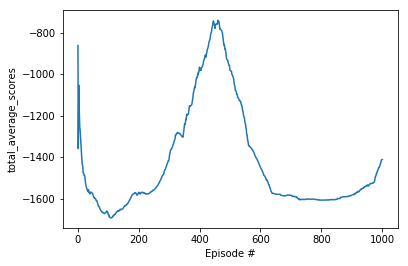

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

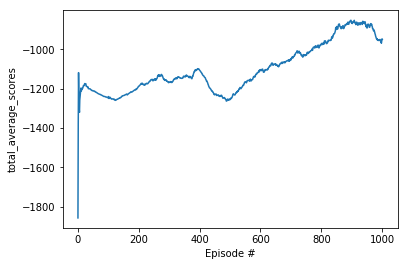

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(np.arange(1, len(meanRs)+1), meanRs)
plt.ylabel('total_average_scores')
plt.xlabel('Episode #')
plt.show()

### 6. Watch the agent running with saved weights

In [14]:
# Load the saved weights into Pytorch model
agent.g.load_state_dict(torch.load('g-pendulum.pth', map_location='cpu'))
agent.d.load_state_dict(torch.load('d-pendulum.pth', map_location='cpu'))

# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# S = env_info.vector_observations                  # get the current states (S) (for each agent)
s = env.reset() # s: state # get the current state (s) (for an agent)

#Rs = np.zeros(num_agents)                          # initialize the total scores (Rs) (for each agent)
R = 0 # R:total reward # initialize the total score (R) (for an agent)

while True:
    #A = agent.act(S)                        # select actions (A) from loaded model agents
    a = agent.act(np.reshape(s, [1, -1])) # a: [-1, +1]    # select action (a) from loaded model agent
    
    # env_info = env.step(A)[brain_name]           # send all actions (A) to tne environment (env)
    # S2 = env_info.vector_observations         # get next states (S2) (for each agent)
    # rewards = env_info.rewards                         # get rewards (for each agent)
    # dones = env_info.local_done                        # see if the episode is done/finished (terminal)
    s2, r, done, _ = env.step(np.reshape(a, [-1]))
    
    # Rs += env_info.rewards                         # update the total scores (Rs) (for each agent)
    # S = S2                               # roll over current states (S) to next states (S2)
    R += r # update the total score (R) (for an agent)
    s = s2 # roll over current state (s) to next state (s2)
    
    #if np.any(dones):                                  # exit loop if episode is done/finished
    if done: # exit loop if episode is done/finished (terminal)
        break
        
print('Average of total scores: {}'.format(R))

FileNotFoundError: [Errno 2] No such file or directory: 'g-pendulum.pth'

When finished, you can close the environment.

In [6]:
env.close()